In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


from src import dataset


tf.random.set_seed(42)
np.random.seed(42)

2026-01-15 19:01:47.438642: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
BATCH_SIZE = 1024

In [3]:
train_ds, val_ds, test_ds = dataset.create_datasets(IMAGE_HEIGHT,IMAGE_WIDTH,BATCH_SIZE)

Number of images:  16970
Attributes:  ['id', 'width', 'height', 'file_name', 'license', 'flickr_url', 'coco_url', 'date_captured']

Number of annotations (they refer to images): 16970
Attributes:  ['id', 'image_id', 'category_id', 'segmentation', 'area', 'bbox', 'iscrowd', 'attributes']

IDs don't always match!
17011 != 17000
Size of paths and labels should be the same:  16970 16970 0
Training samples: 10182
Validation samples: 3394
Testing samples: 3394


2026-01-15 19:02:01.086985: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2026-01-15 19:02:01.087043: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2026-01-15 19:02:01.476485: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2026-01-15 19:02:01.476535: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2026-01-15 19:02:01.476562: I external/local_xla/xla/stream_executor/rocm/rocm_executor.

2026-01-15 19:02:07.875721: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


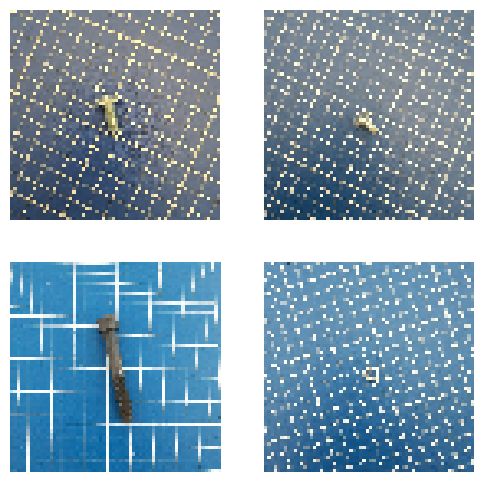

2026-01-15 19:02:07.937124: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [4]:
for images, labels in train_ds.take(1):
    plt.figure(figsize=(6,6))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.imshow(images[i].numpy())
        plt.axis("off")
    plt.show()


In [5]:
def build_baseline_model(num_classes):
    model = models.Sequential([
        layers.Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3)),

        layers.Conv2D(32, kernel_size=3, activation="relu"),
        layers.MaxPooling2D(),

        layers.Conv2D(64, kernel_size=3, activation="relu"),
        layers.MaxPooling2D(),

        layers.Conv2D(128, kernel_size=3, activation="relu"),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dense(num_classes, activation="softmax"),
    ])

    return model

In [6]:
model = build_baseline_model(num_classes=6)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 683,974 (2.61 MB)

 Trainable params: 683,974 (2.61 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [11]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
)


Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 289ms/step - accuracy: 0.3408 - loss: 1.7339 - val_accuracy: 0.3930 - val_loss: 1.5212
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 289ms/step - accuracy: 0.4595 - loss: 1.4085 - val_accuracy: 0.5177 - val_loss: 1.3147
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 289ms/step - accuracy: 0.5461 - loss: 1.2304 - val_accuracy: 0.5684 - val_loss: 1.2047
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 289ms/step - accuracy: 0.6109 - loss: 1.0843 - val_accuracy: 0.6049 - val_loss: 1.0843
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 289ms/step - accuracy: 0.6633 - loss: 0.9480 - val_accuracy: 0.6479 - val_loss: 0.9919
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 289ms/step - accuracy: 0.7015 - loss: 0.8477 - val_accuracy: 0.6830 - val_loss: 0.9020
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 291ms/step - accuracy: 0.7335 - loss: 0.7663 - val_accuracy: 0.7033 - val_loss: 0.8398
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 292ms/step - accuracy: 0.7551 - loss: 0.7070 - val_accuracy: 0.

In [12]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7864 - loss: 0.6176
Test accuracy: 0.786


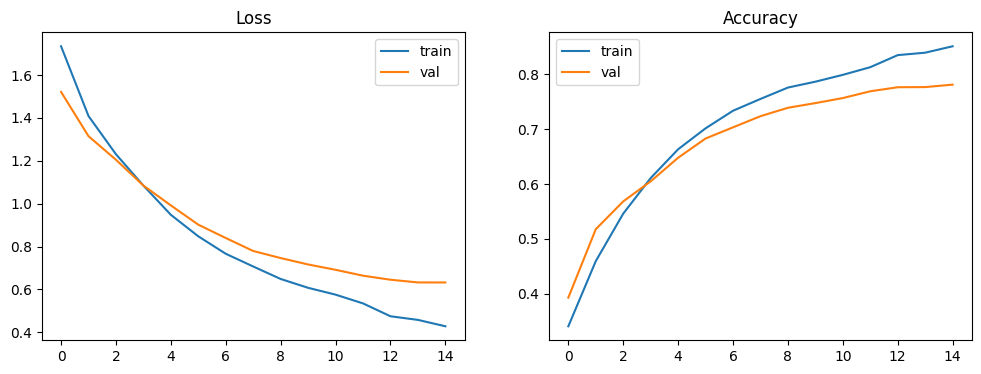

In [13]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy")
plt.legend()

plt.show()
